/tmp/ipykernel_22583/1475660902.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  return scipy.special.erf(L * x / np.sqrt(1 - x**2))


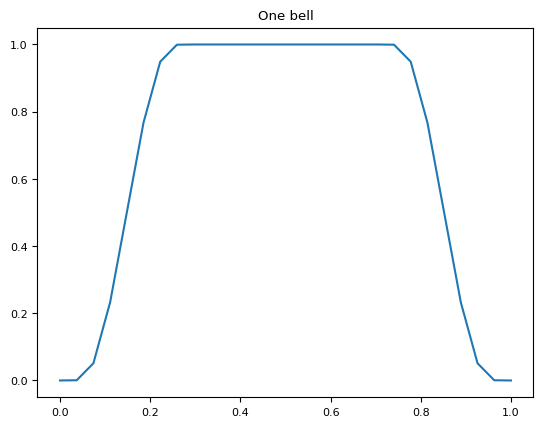

[0.00000000e+00 6.70320559e-04 5.12352174e-02 2.32604409e-01
 5.00000000e-01 7.67395591e-01 9.48764783e-01 9.99329679e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99329679e-01 9.48764783e-01 7.67395591e-01 5.00000000e-01
 2.32604409e-01 5.12352174e-02 6.70320559e-04 0.00000000e+00]


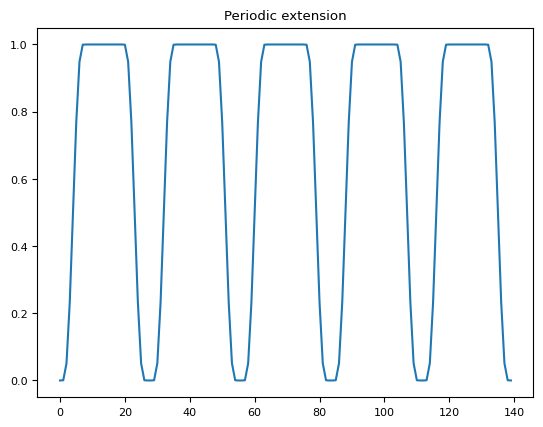

In [100]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 


# Asymptotic Fourier Coefficients for a C ∞ Bell
#(Smoothed-“Top-Hat”) & the Fourier Extension
#Problem
#John P. Boyd 1

#Eq. 2
def erflike(x, L):
    if x < -1:
        return -1
    elif x > 1:
        return  1
    else:
        return scipy.special.erf(L * x / np.sqrt(1 - x**2))

#Eq. 3
def ramp(x, L):
    return 0.5 * (1 + erflike(x, L))

#Eq. 5
def bell(x, L, chi, psi): 
#   Eq. 4
    Omega = (psi - chi) / 2
    if -psi <= x and x < -chi: 
        return ramp(+(x + chi + Omega)/Omega, L)
    elif -chi <= x and x < chi: 
        return 1
    else:
        return ramp(-(x - chi - Omega)/Omega, L)
    
def scaleToPsi(x, psi): 
    dx = x[1] - x[0]
    a = x[ 0]
    b = x[-1]
    xs = (x - a) / (b - a) 
    xs = xs * (2 * psi) - psi
    return xs

def getBell(xx, ghostBoundary, L): 

    psi = 1
    xs = scaleToPsi(xx, psi)
    chi = psi - (xs[ghostBoundary] - xs[0])
    y = np.array([bell(r, L, chi, psi) for r in xs]) 
    return y, chi, psi

N = 28 
Ngh = 8
x = np.linspace(0, 1, N)
y, chi, psi = getBell(x, Ngh, 2)
plt.title("One bell")
plt.plot(x, y)
plt.show()
print(y)

xext = np.zeros(5*N) 
for i in range(5): 
    xext[i*N: (i+1)*N] = y

plt.title("Periodic extension")
plt.plot(xext)

/tmp/ipykernel_22583/1475660902.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  return scipy.special.erf(L * x / np.sqrt(1 - x**2))
/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


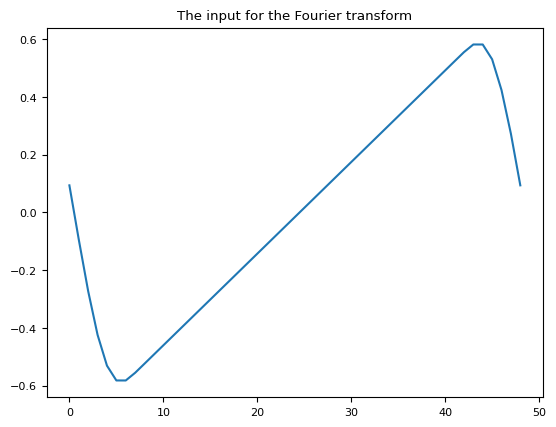

In [200]:

def scaleToPsi(x, psi): 
    dx = x[1] - x[0]
    a = x[ 0]
    b = x[-1]
    xs = (x - a) / (b - a) 
    #dx = (xs[1] - xs[0]) * 2 * psi
    xs = xs * (2 * psi) - psi
    

    return xs

#####################################################################################################
#
# -2*psi+chi       -psi                -chi          0          chi              psi        2*psi-chi
# -------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxx-----------------------------------
#        ghost boundary                        physical domain                    ghost boundary
#
# 
######################################################################################################
def getIntricateBell(xx, f, ghostBoundary, L): 

    # We set length of physical domain to 1
    # 2 * psi = C * (len(f) - 2 * ghostBoundary)
    # Half of the ghost boundary is extension domain 
    # chi = C * 2 * ghostBoundary / 2
    chi          = (len(f) - 2 * ghostBoundary)/2
    psi          = (len(f) -     ghostBoundary)/2 
    #rescale psi so that it takes the value 2 * psi - chi at the boundaries
    xs           = scaleToPsi(xx, 2 * psi - chi)
    twopsishift  = len(f) - ghostBoundary


    y  = np.zeros(f.shape, dtype=complex)
    for i, x in enumerate(xs): 
        Omega = (psi - chi) / 2
        if x < -chi:
            #print(i, twopsishift, i + twopsishift)
            y[i] = bell(xs[i], L, chi, 2 * psi - chi) * f[i] + bell(xs[i + twopsishift], L, chi, 2 * psi - chi) * f[i + twopsishift]
        elif -chi <= x and x <= chi: 
            y[i] = f[i]
        elif chi < x:
            y[i] = bell(xs[i], L, chi, 2 * psi - chi) * f[i] + bell(xs[i - twopsishift], L, chi, 2 * psi - chi) * f[i - twopsishift]

    if 0:
        print("Psi: ", psi, " Chi: ", chi, " 2Psi-Chi ", 2*psi -chi, " 2chi: ", 2*chi, "xs: ", xs)
        print(y - f)
        plt.title("The full function for more than one period ")
        plt.plot(xs, y) 
        plt.show()
    halfGhost    = int(ghostBoundary/2) 
    x = xs[halfGhost-1:-halfGhost]
    y = y[halfGhost-1:-halfGhost]
    return y, chi, psi

N = 64
Ngh = 16
Ntps = N - Ngh 
x = np.linspace(-1, 1, N)
L = 1.3 * np.sqrt(1 - chi/psi) * np.sqrt(len(x)/2)
f = x

y, chi, psi = getIntricateBell(x, f, Ngh, 2)
plt.title("The input for the Fourier transform")
plt.plot(y)
plt.show()

In [196]:


# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

class NaiveBellScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.psi     = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.fields  = self.psi 
        self.counter = 0
        b1, chi, psi = getBell(self.grid[0], self.ghostBoundarySize, 1)
        L            = 0.911 * np.sqrt(1 - chi/psi) * np.sqrt(len(x)/2)
        self.bell,_,_= getBell(self.grid[0], self.ghostBoundarySize, L)


    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]
        
        psip = self.bell * self.psi 
        fhat = scipy.fft.fft(psip)
        k = sd.computeK(fhat, self.dx, sd.PERIODIC) 
        fhat = np.exp(-Coeff1 * k**2) * fhat
        self.psi = scipy.fft.ifft(fhat)

        self.t += dt

    def getName(self):
        return "naive bell scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]
    

class IntricateBellScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.psi     = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.fields  = self.psi 
        self.counter = 0
        b1, chi, psi = getIntricateBell(self.grid[0], self.psi, self.ghostBoundarySize, 1)
        self.L = 1.3 * np.sqrt(1 - chi/psi) * np.sqrt(len(x)/2)


    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]

        halfGhost = int(self.ghostBoundarySize/2)

        y,_,_    = getIntricateBell(self.grid[0], self.psi, self.ghostBoundarySize, self.L)
        if 0:
            plt.title("Before bell") 
            plt.plot(np.abs(self.psi))
            plt.show() 
            plt.title("After bell") 
            plt.plot(np.abs(y))
            plt.show() 
        fhat     = scipy.fft.fft(y)
        k        = sd.computeK(fhat, self.dx, sd.PERIODIC) 
        plt.title("fhat") 
        plt.plot(k, np.abs(fhat))
        plt.yscale("log") 
        plt.show() 
        fhat     = np.exp(-Coeff1 * k**2) * fhat
        self.psi[halfGhost:-halfGhost]= scipy.fft.ifft(fhat)

        self.t += dt

    def getName(self):
        return "intricate bell scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]


### Naive Bell

/tmp/ipykernel_22583/1475660902.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  return scipy.special.erf(L * x / np.sqrt(1 - x**2))


Finished in 2403 time steps


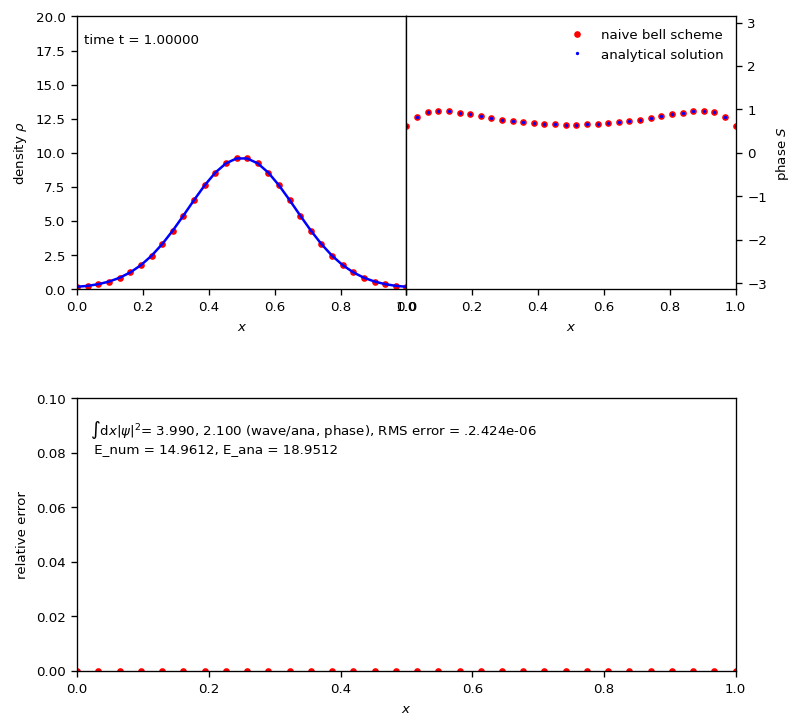

In [197]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = x[-1] - x[0]
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 32
c["boundarySize"]               = 16
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
scheme = NaiveBellScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)

### Intricate Bell

/tmp/ipykernel_22583/1475660902.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  return scipy.special.erf(L * x / np.sqrt(1 - x**2))


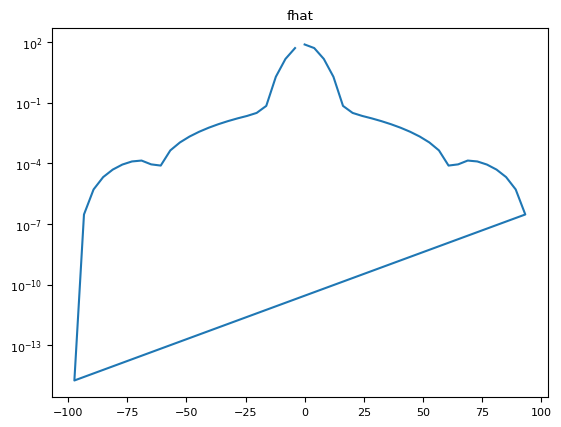

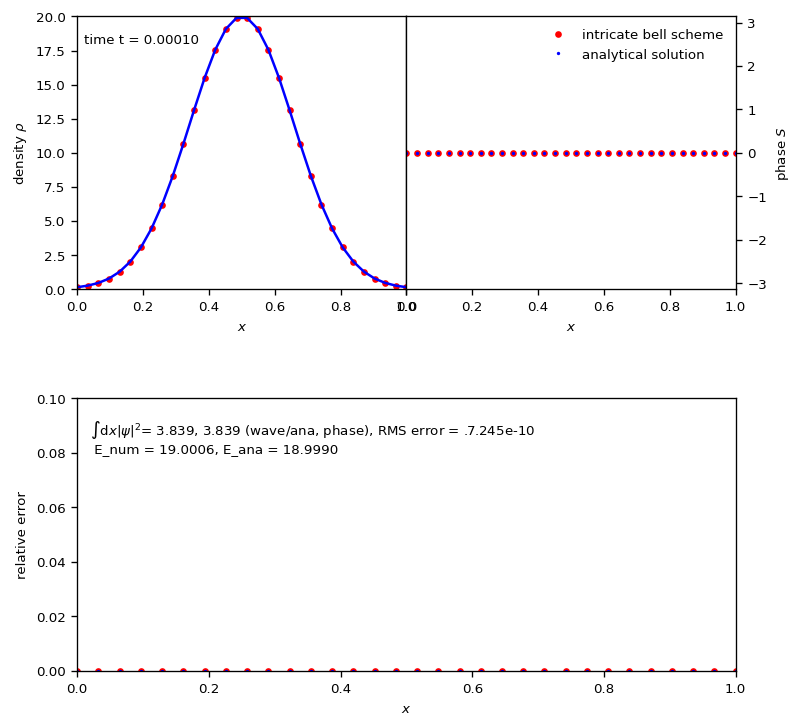

In [198]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = x[-1] - x[0]
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 32
c["boundarySize"]               = 16
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
scheme = IntricateBellScheme(c, periodic1DGaussian) 
scheme.run
animation.drawFrame(scheme)

In [407]:

class SubregionScheme(Scheme):
    def __init__(self, config, generateIC, scheme):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch = int(self.innerN/self.patchSize)
        self.patchWidth = self.dx * (self.patchSize - 1)

        if self.print_grid: 
            print(f"Domain size = {self.Lh - self.Ll} Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        self.patches = []
    
        patchConfig = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"] = False
        for i in range(self.NPatch):
            patchConfig["domainSize"] = [self.L0 + (i) * self.dx * self.patchSize, self.L0 + i * self.dx * self.patchSize + self.patchWidth]
            self.patches.append(scheme(patchConfig, generateIC))
            if self.print_grid:
                print(f"Patch {i}: domainSize: ", patchConfig["domainSize"], " the grid: ", self.patches[i].grid, " dx: ", self.patches[i].dx)

        if self.print_grid:
            print("The master grid: domainSize: ", config["domainSize"], " the grid: ", self.grid, " dx: ", self.dx)

        #Make sure everything agrees on the bit-level
        for i in range(self.NPatch):
            self.patches[i].dx = self.dx 

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if self.print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])

        self.debugWavefunction = False 
        self.debugShiftfunction = False 


    #def getUpdatedFields(self, t, dt, old_psi):
    def step(self, dt):
        #self.psi = np.copy(old_psi)

        print_grid = self.print_grid
        
        if 0:
            plt.title("Before boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        if 1:
            f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)

            if print_grid:
                print(f"Writing BC to {self.boundary}")


            #Set outer ghost zone
            self.psi[self.boundary] = f[self.boundary]

        else:
            self.psi[ :self.ghostBoundarySize] = np.roll(self.psi, 2*self.ghostBoundarySize)[:self.ghostBoundarySize]
            self.psi[-self.ghostBoundarySize:] = np.roll(self.psi,-2*self.ghostBoundarySize)[-self.ghostBoundarySize:]

        if 0:
            plt.title("After boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        patchpgb  = self.patchSize + 2 * self.ghostBoundarySize

        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])
            if print_grid:
                print(f"This means the points {self.grid[0][ i0 : i1 ]} that should include the patch's boundary points {self.patches[i].grid[0][self.patches[i].boundary]} ")
            

        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction = self.debugWavefunction 
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)

        #Write updated patch data back to global array
        for i in range(self.NPatch):
            i0 = self.ghostBoundarySize + i * self.patchSize
            i1 = self.ghostBoundarySize + (i + 1) * self.patchSize

            if print_grid:
                    print(f"Writing patch {i} inner {self.patches[i].inner[0], self.patches[i].inner[-1] - 1} to [{i0}, {i1 - 1}]")
            self.psi[ i0 : i1 ] = self.patches[i].psi[self.patches[i].inner]
        
        self.t += dt
        #return self.psi# - old_psi



    def getName(self):
        return "subregion scheme"
    

    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        t3 = 1e6#self.ghostBoundarySize * 4/np.pi**2  * self.dx**3
        
        return np.min([t1, t2, t3])


Finished in 40323 time steps


(2.8999787529589916e+20, 2.998985069155458e+20)

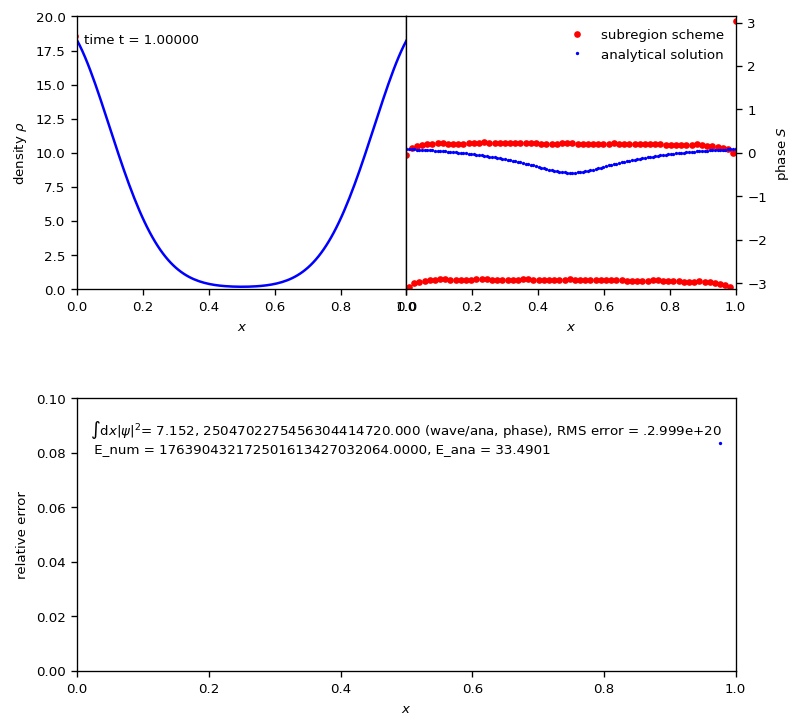

In [415]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 128
c["patchSize"]                  = 16
c["boundarySize"]               = 8
c["useBC"]                      = False
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
c["printGrid"]                  = False
scheme = SubregionScheme(c, periodic1DGaussian, FourierExtensionScheme) 
scheme.run()
animation.drawFrame(scheme)
scheme.computeRelError(), scheme.computeRMSError()

[-1.         -0.95652174 -0.91304348 -0.86956522 -0.82608696 -0.7826087
 -0.73913043 -0.69565217 -0.65217391 -0.60869565 -0.56521739 -0.52173913
 -0.47826087 -0.43478261 -0.39130435 -0.34782609 -0.30434783 -0.26086957
 -0.2173913  -0.17391304 -0.13043478 -0.08695652 -0.04347826  0.
  0.04347826  0.08695652  0.13043478  0.17391304  0.2173913   0.26086957
  0.30434783  0.34782609  0.39130435  0.43478261  0.47826087  0.52173913
  0.56521739  0.60869565  0.65217391  0.69565217  0.73913043  0.7826087
  0.82608696  0.86956522  0.91304348  0.95652174  1.        ]
Finished in 4806 time steps


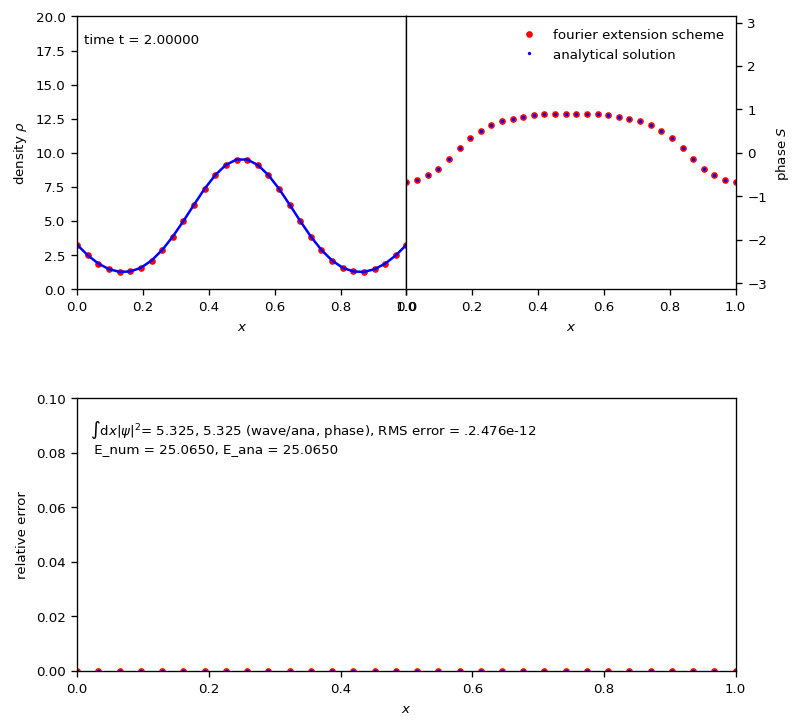

In [337]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = x[-1] - x[0]
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2.0
c["resolution"]                 = 32
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
scheme = FourierExtensionScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)


In [402]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2.0
c["resolution"]                 = 128
c["patchSize"]                  = 32
c["boundarySize"]               = 8
c["useBC"]                      = False
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
c["printGrid"]                  = False

scheme = SubregionScheme(c, periodic1DGaussian, FourierExtensionScheme) 
scheme.run()
animation.drawFrame(scheme)

KeyboardInterrupt: 